# Introduction to Deep Learning - Final Project

In this project we decided to implement Gans model to generate landscape images from segmented images .
We used pix2pix model which is an arcticture to do Image-to-image translation with a conditional GAN . 

Hope you will find this project interesting, 

Shani Klein and Eran Lapushnian

## Import TensorFlow and other libraries

In [42]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display

import numpy as np
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from scipy.linalg import sqrtm

In [43]:
# install so we can see results on tensorboard
!pip install -U tensorboard

In [44]:
from google.colab import drive
import sys
# mount to drive
drive.mount('/content/gdrive/')
sys.path.append('/content/gdrive/My Drive/Intro_to_Deep_Learning/Final_project')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [45]:
# Model parameters
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

## Choosing and Load the dataset
We chose to use ADE20k-Outdoors dataset.
The ADE20K semantic segmentation dataset contains more than 20K scene-centric images exhaustively annotated with pixel-level objects and object parts labels. There are totally 150 semantic categories, which include stuffs like sky, road, grass, and discrete objects like person, car, bed. 

To make training faster and easier we chose to take ADE20k-Outdoors dataset which contains 5,000 outdoor images from the ADE20K image segmentation landmark dataset.


First we chose to work with TensorFlow hence we needed to decode the image to tensors. Real images have 'jpg' format and annotation (segmented) images have 'png' hence we added an extra argumeng "im_type" so we can decode each image according to it's type.

In [46]:
def load(image_file,im_type):
  image = tf.io.read_file(image_file)
  # real image with type 'jpg'
  if(im_type=='jpg'):
    image = tf.image.decode_jpeg(image)
  # segmented image with type 'png
  elif (im_type=='png'):
    image = tf.image.decode_png(image)
    image=tf.image.grayscale_to_rgb(image)
  
  image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  
  image=tf.cast(image, tf.float32) 
  return image


In [47]:
PATH='/content/gdrive/MyDrive/Intro_to_Deep_Learning/Final_project/ADE20k_outdoors_splitted'

Let Visualize some input image and the real image we expect

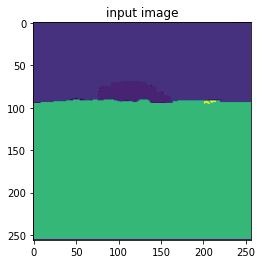

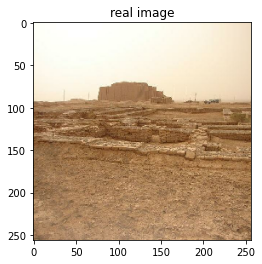

In [48]:
inp = load(PATH+'/annotations/training/ADE_train_00020201.png','png')
re = load(PATH+'/images/training/ADE_train_00020201.jpg','jpg')

plt.figure()
plt.title("input image")
plt.imshow(inp[:,:,0]/255.0)
plt.figure()
plt.title("real image")
plt.imshow(re/255.0)

In [49]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [50]:
def random_crop(input_image, real_image):
  print(real_image.shape)
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [51]:
# normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

#### Add augmentation
We tried several augmentation such as random cropping, flip horizonly and flip verticaly.

In [52]:
@tf.function()
def augmentation(input_image, real_image):
  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

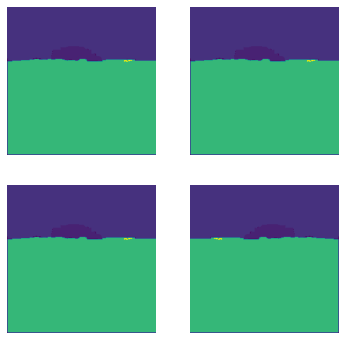

In [53]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = augmentation(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp[:,:,0]/255.0)
  plt.axis('off')
plt.show()

We can tell that some images were randomnly fliped and some not.

In [54]:
def load_image_train(image_file):
  file_path=tf.strings.split(image_file,PATH)[1]
  # path to annotaion of the image
  annotation_path=[PATH+'/annotations/',tf.strings.split(file_path,'/',2)[2]]
  # annotation file is .png file not jpg
  annotation_path=[tf.strings.split(tf.strings.join(annotation_path,''),'.')[0],'png']
  annotation_file=tf.strings.join(annotation_path,'.')
  
  real_image=load(image_file,'jpg')
  input_image=load(annotation_file,'png')

  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [55]:
def load_image_test(image_file):
  file_path=tf.strings.split(image_file,PATH)[1]
  # path to annotaion of the image
  annotation_path=[PATH+'/annotations/',tf.strings.split(file_path,'/',2)[2]]
  # annotation file is .png file not jpg
  annotation_path=[tf.strings.split(tf.strings.join(annotation_path,''),'.')[0],'png']
  annotation_file=tf.strings.join(annotation_path,'.')
  
  real_image=load(image_file,'jpg')
  input_image=load(annotation_file,'png')
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

## Input Pipeline
First we create list of all real images file in the training\validation directory .
Then we are using map to apply load_image_train or load_image_test to each file name.
In load_image_train we parse string to image file and then get the path of annotation file by splitting the name and find the corresponding file in the annotation directory.

Last,we shuffle our dataset.

In [56]:
train_dataset = tf.data.Dataset.list_files(PATH+'/images/training/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [57]:
test_dataset = tf.data.Dataset.list_files(PATH+'/images/validation/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Building GANs model 
As we leanrt in class when building GAN model we want to train a generator model, for generating realimages and a discriminator model that will classify images as real (from the dataset) or fake (generated), and the generator is trained to fool the discriminator model.


### Build the Generator
  * The architecture of generator is a modified U-Net -the U-Net model is a simple fully convolutional neural network which consists of two parts:

    *Contracting Path*: we apply a series of conv layers and downsampling layers (max-pooling) layers to reduce the spatial size
    
    *Expanding Path*: we apply a series of upsampling layers to reconstruct the spatial size of the input.
The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1.
![U-net Architecture](https://paperswithcode.com/media/methods/Screen_Shot_2020-07-07_at_9.08.00_PM_rpNArED.png)

  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).


In [58]:
OUTPUT_CHANNELS = 3

In [59]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

Here we can tell that if we put an (256,256,3) - after applying downsampling we get (128,128,3) size imgage.

In [60]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [61]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

Noe we take the downsampled image and apply upsampling - we can tell we got back an (256,256,3)

In [62]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [63]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
    downsample(128, 4),  # (bs, 64, 64, 128)
    downsample(256, 4),  # (bs, 32, 32, 256)
    downsample(512, 4),  # (bs, 16, 16, 512)
    downsample(512, 4),  # (bs, 8, 8, 512)
    downsample(512, 4),  # (bs, 4, 4, 512)
    downsample(512, 4),  # (bs, 2, 2, 512)
    downsample(512, 4),  # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
    upsample(512, 4),  # (bs, 16, 16, 1024)
    upsample(256, 4),  # (bs, 32, 32, 512)
    upsample(128, 4),  # (bs, 64, 64, 256)
    upsample(64, 4),  # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

#### **Visualize and Test the generator**





 Visualize the generator model architecture

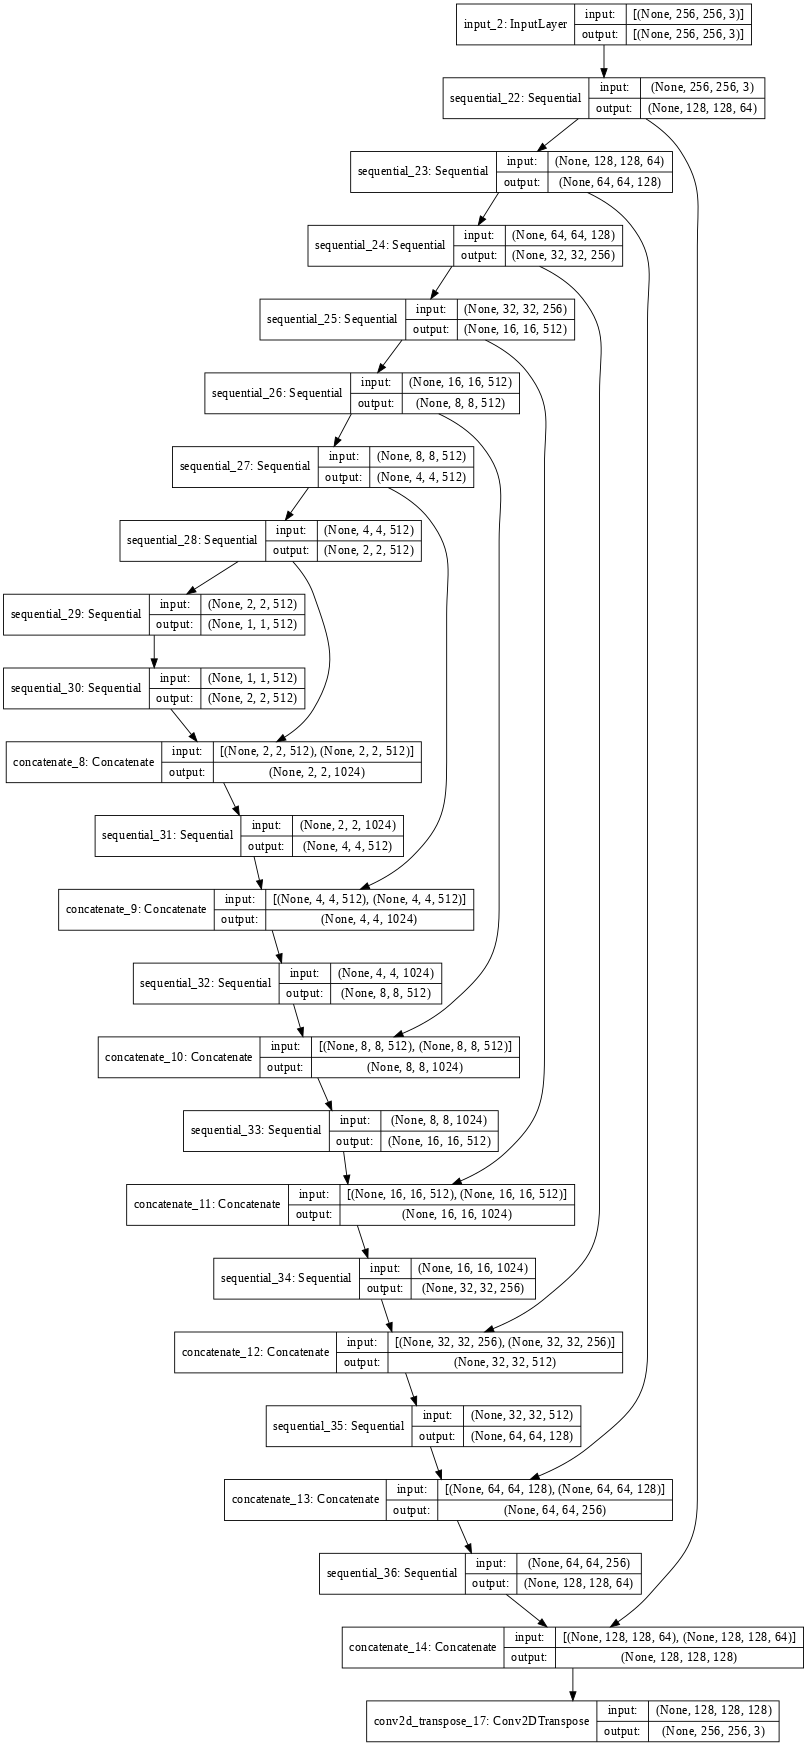

In [64]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Test the generator code is working (without training)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


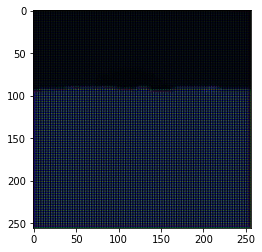

In [65]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

we can tell the code is working . we obviously see a white noise added to the segmented image. We expect the image to become more realistic after training.

#### **Define the generator loss**
GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image/

  * The genrator loss per image is a sigmoid cross-entropy loss of the generated images and an array of ones. 
  * in addition we take L1 loss between the generated image and the target image.

The formula to calculate the total generator loss:
  generator loss = gan_loss + LAMBDA * l1_loss
  
  Where in our case LAMBDA = 100. 

In [66]:
LAMBDA = 100

In [67]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [68]:
def calculate_statistics(images,model):
  act = model.predict(images)
  mu, sigma = act.mean(axis=0), cov(act, rowvar=False)
  sigma = np.atleast_2d(sigma)
  return mu,sigma

In [69]:
# calculate frechet inception distance
def calculate_generator_statistics(images,generator_model,inception_model):
  # prepare the inception v3 model
  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  x = generator_model(inp,training=True)
  x = inception_model(x)
  model = tf.keras.Model(inputs=inp,outputs=x)
  mu,sigma = calculate_statistics(images,model)
  return mu,sigma
  
def calculate_fid(mu1,sigma1,mu2,sigma2):
  # calculate sum squared difference between means
  ssdiff = np.sum((mu1 - mu2)**2.0)
  # calculate sqrt of product between cov
  covmean = sqrtm(sigma1.dot(sigma2))
  # check and correct imaginary numbers from sqrt
  if iscomplexobj(covmean):
    covmean = covmean.real
  # calculate score
  fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid

In [70]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

The training procedure for the generator: the generator get the segmented image as an input , the output of the generator used for both calculate the MAE cost function of the difference between the target image and the generated image. In addition, th output of the generator is also used as the input of the discriminator.

Hence, when aplying gradient decent the gererator is generator being update accoding to both MAE and cross entorpy losses.


![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## Build the Discriminator
  * The Discriminator is a PatchGAN, meaning after feeding one input image to the network, it gives you the probabilities of two things: either real or fake, but not in scalar output. It used the NxN output vector (in our case N=30).

  * Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
  * The shape of the output after the last layer is (batch_size, 30, 30, 1)
  * Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
  * Discriminator receives 2 inputs.
    * Input image and the target image, which it should classify as real.
    * Input image and the generated image (output of generator), which it should classify as fake.
    * Concatenate these 2 inputs together in the code (`tf.concat([inp, tar], axis=-1)`)

In [71]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)
  
  down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

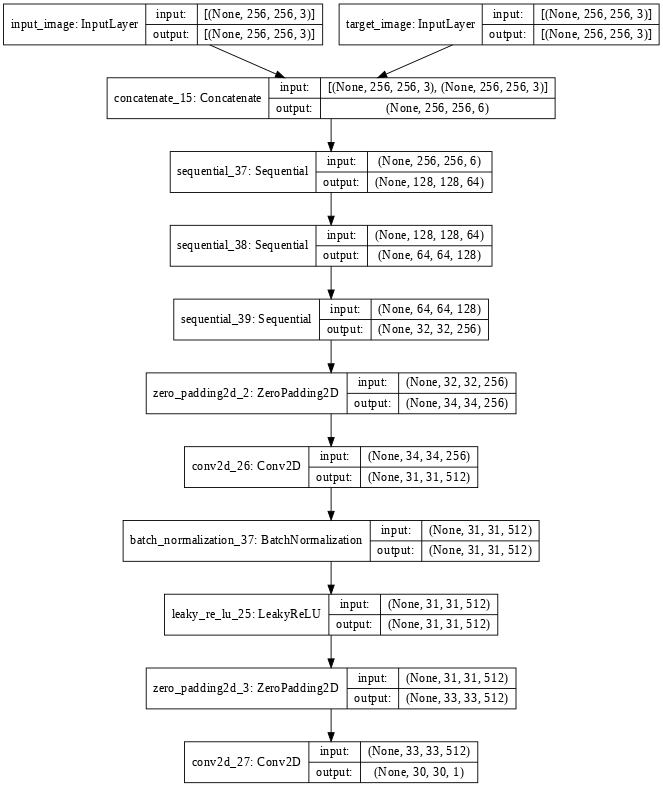

In [72]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

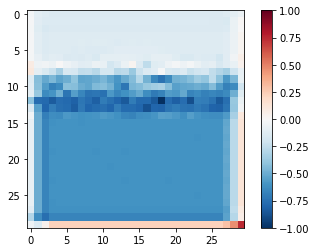

In [73]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-1, vmax=1, cmap='RdBu_r')
plt.colorbar()

**Discriminator loss**
  * The discriminator loss function takes 2 inputs: **real images, generated images**
  * real_loss is a sigmoid cross entropy loss of the **real images** and an **array of ones(since these are the real images)**
  * generated_loss is a sigmoid cross entropy loss of the **generated images** and an **array of zeros(since these are the fake images)**
  * Then the total_loss is the sum of real_loss and the generated_loss


In [74]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

The training procedure for the discriminator is shown below:
the discriminator works in 2 pathes: first path is comapre target images and input images to 1s matrix to check if it is a real images, and second path is comapring the generated images to 0s matrix to check if it is a fake image. Both error defined by cross entropy and a sigmoid to get probabilities.




![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## Define the Optimizers and Checkpoint-saver


In [75]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [76]:
CHECKPOINT_PATH='/content/gdrive/MyDrive/Intro_to_Deep_Learning/Final_project'
checkpoint_dir = CHECKPOINT_PATH+'/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate Images

Here we wrote a function to plot some images during training.
in the function we first pass images from the test dataset to the generator,the generator will then translate the input image into the output. Last step is to plot the predictions.

In [77]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0][:,:,0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])

    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

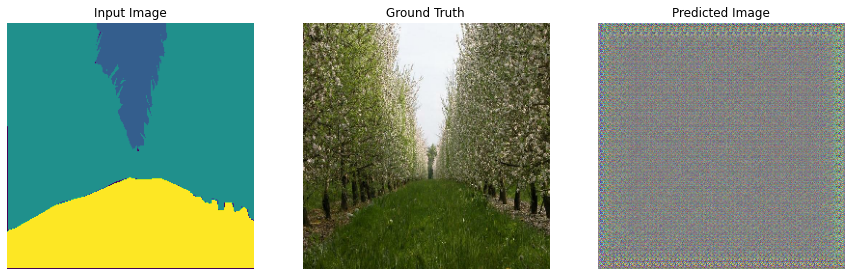

In [78]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

## Training

* For each example input generate an output.
* The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
* Next, calculate the generator and the discriminator loss.
* Then, calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* Then log the losses to TensorBoard.

In [79]:
EPOCHS = 50

In [80]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [81]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)
    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)
    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

  return gen_total_loss,gen_gan_loss,gen_l1_loss,disc_loss

The actual training loop:

* Iterates over the number of epochs.
* On each epoch it clears the display, and runs `generate_images` to show it's progress.
* On each epoch it iterates over the training dataset, printing a '.' for each example.
* It saves a checkpoint every 20 epochs.

In [82]:
def fit(train_ds, epochs, test_ds,inception_model):
  gen_total_losses,gen_gan_losses,gen_l1_losses,disc_losses,fids=[],[],[],[],[]
  mu1,sigma1 = calculate_statistics(train_ds,inception_model)

  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      if input_image.shape!=target.shape: # work around
        continue
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
        gen_total_loss,gen_gan_loss,gen_l1_loss,disc_loss= train_step(input_image, target, epoch)

    print()
    gen_total_losses.append(gen_total_loss)
    gen_gan_losses.append(gen_gan_loss)
    gen_l1_losses.append(gen_l1_loss)
    disc_losses.append(disc_loss)
    


    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)
      # compute fid
      mu2,sigma2 = calculate_generator_statistics(train_ds,generator,inception_model)
      fid = calculate_fid(mu1,sigma1,mu2,sigma2)
      fids.append(fid)


    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix=checkpoint_prefix)
  with summary_writer.as_default():
    tf.summary.scalar('FID', fid, step=epoch)

  return gen_total_losses,gen_gan_losses,gen_l1_losses,disc_losses,fids

This training loop saves logs to TensorBoard so we can monitor the training progress later on .

### **Evaluate our model**
We used the SOTA wat to evaluate Gans model which is FID .
The best FID score to image-to-image transaltion using ADE20k-outdooe is between 67-120 as we can see in the table below:

 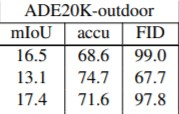



#### **Frechet Inception Distance - FID**
The Frechet Inception Distance score (FID) is a metric that calculates the distance between feature vectors calculated for real and generated images.

The inception score estimates the quality of a collection of synthetic images based on how well the top-performing image classification model Inception v3 classifies them. The lower the FID score, better the quality of the image. Perfect score of 0 indicates that the two groups of images are identical.

$d^2 = ||\mu_1 – \mu_2||^2 + Tr(C_1 + C_2 – 2 \sqrt {C_1C_2}$

where $\mu_1$, $\mu_2$ refer to the feature-wise mean of the real and generated images.And The $C_1$, $C_2$ are the covariance matrix for the real and generated feature vectors.

In our project we calculated the FID score between the trainig data to the generated images from the generator by using the following functions:

calculate_statistics - calculates the mean and sigma for the inception model ($\mu_1,C_1$)

calculate_generator_statistics - calculates the mean and sigma for the generator model ($\mu_2,C_2$).

calculate_fid - calculates the FID score using the formula given above and $\mu_1,\mu_2,C_1,C_2$. 

Now run the training loop:

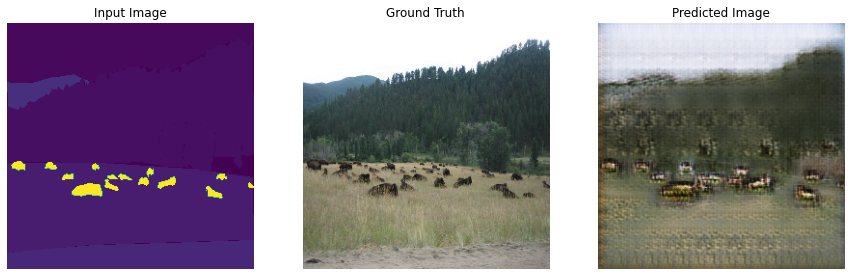

Epoch:  49
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

In [ ]:
inception_model = tf.keras.applications.InceptionV3(input_shape=(256,256,3),pooling="avg",include_top=False)
inception_model.trainable = False
gen_total_losses,gen_gan_losses,gen_l1_losses,disc_losses,fids=fit(train_dataset, EPOCHS, test_dataset,inception_model)

Text(0, 0.5, 'fid')

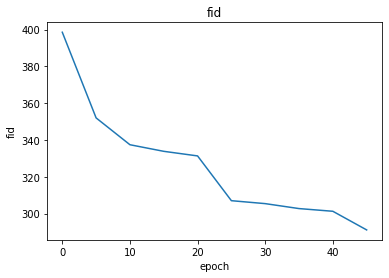

In [ ]:
plt.plot([5*i for i in range(int(EPOCHS/5))],fids)
plt.title('fid')
plt.xlabel('epoch')
plt.ylabel('fid')

we can see our FID gets better and better over time. However we are still far from the SOTA model .

In [ ]:
# display.IFrame(
#     src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
#     width="100%",
#     height="1000px")

In [ ]:
# get results from tensorboard
import tensorboard as tb
experiment_id = "lZ0C6FONROaUMfjYkVyJqw"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()


Text(0.5, 1.0, 'gen_l1_loss')

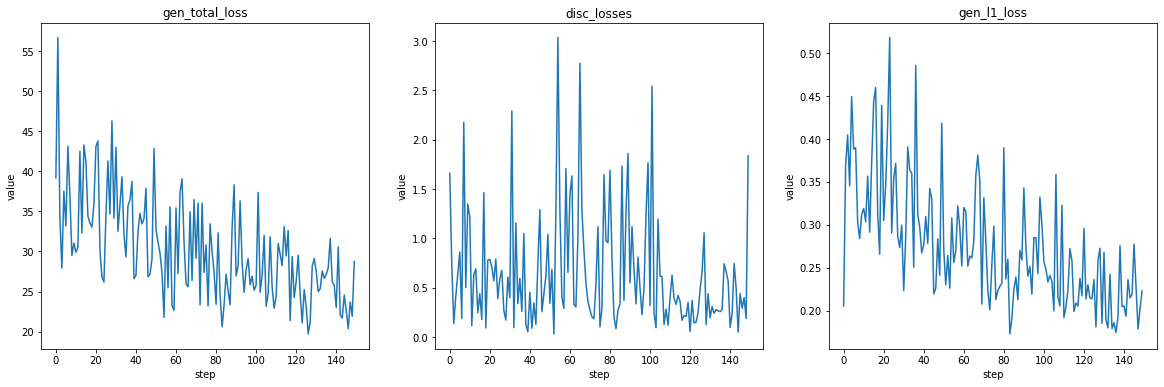

In [ ]:
import seaborn as sns
disc_losses = df[df['tag']=='disc_loss']
gen_total_losses = df[df['tag']=='gen_total_loss']
gen_l1_loss=df[df['tag']=='gen_l1_loss']
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
sns.lineplot(data=gen_total_losses, x="step", y="value").set_title("gen_total_loss")
plt.subplot(1, 3, 2)
sns.lineplot(data=disc_losses, x="step", y="value").set_title("disc_losses")
plt.subplot(1, 3, 3)
sns.lineplot(data=gen_l1_loss, x="step", y="value").set_title("gen_l1_loss")


We can tell that the genertor indeed trained and the generator loss is maybe noisy but decreasing as we do more steps. In the other hand the discriminator may not be as good as the discriminator which make sense becasue at the beginning - the generaor was not so good so the discriminator was able to predict the image is fake easily. As the generator became better and better the discriminator find it harder to predict wether the image is real or fake.

* The value `log(2) = 0.69` is a good reference point for the losses, as it indicates a perplexity of 2: That the discriminator is on average equally uncertain about the two options.
* For the `gen_gan_loss` a value below `0.69` means the generator is doing better than random at fooling the descriminator. In our case all our value of gen loss is under 0.69.
* For the `disc_loss` a value below `0.69` means the discriminator is doing better than random, on the combined set of real+generated images. In our case we can tell that it is not balanced- somtimes we get result lower that 0.69 and sometimes not, which shows that as much that the generator becomes better the discriminator is struggeling to predict.
* As training progresses the `gen_l1_loss` should go down and this is the case so it is good for us.

## Restore the latest checkpoint and test

In [ ]:
# !ls {checkpoint_dir}

In [84]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate using test dataset - 
lets test our model on the test data

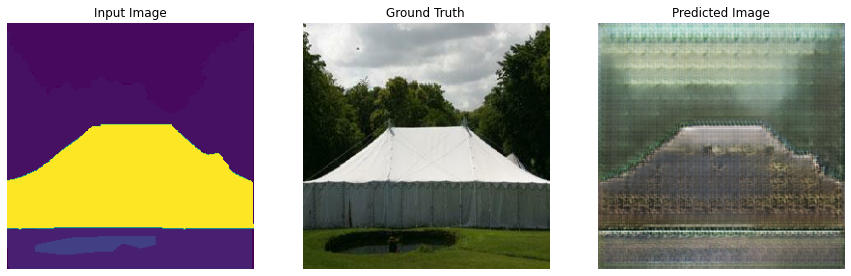

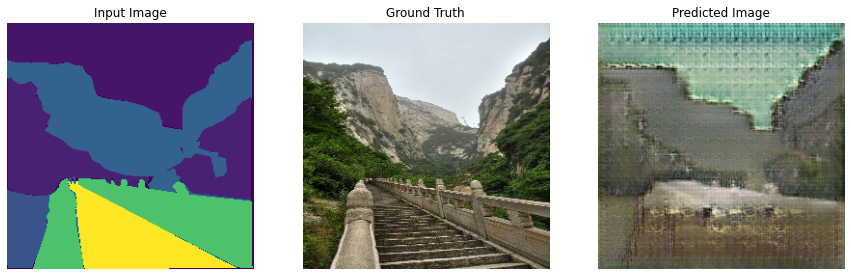

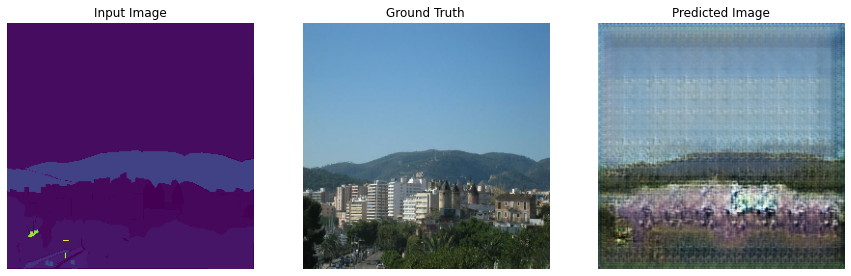

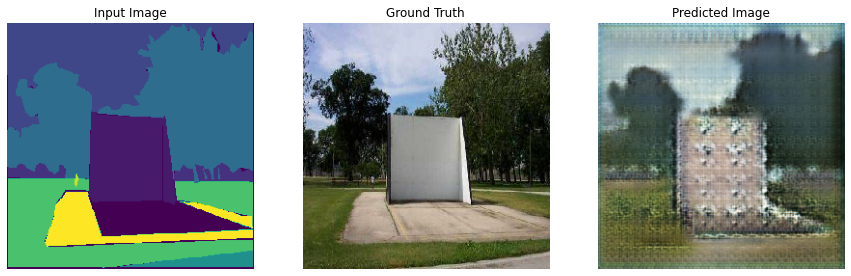

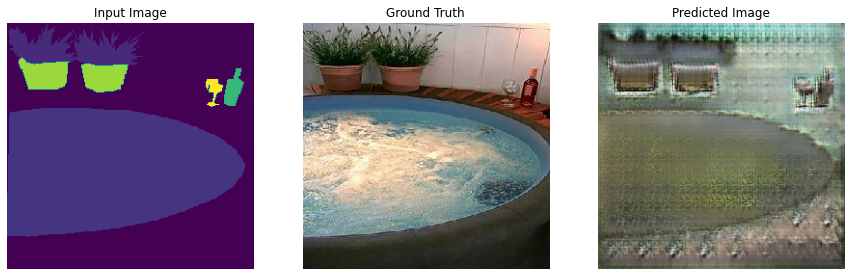

In [85]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

## Results analysis- 
the model may not be the best model - it is pretty clear the images we generated is not real images.Hoewvwe, we did succeed in capture the colors of the images such as sky,grass ,trees and ect, we did succeed to capute the details in the images and structures of objects.
the images are not just random but startining to look more like a real image. In addition, the model did not get saturated and we can tell by those generated imaged that it indeed seems that with some more training the model will be able to get better and better.




## Conclustions- 
We leant a lot in this project- we learnt how to build a GAN model from scratch - how to define the tranining function ,how to define each block in the generator and the discriminator using upsamling and downsamnping. We learnt how to evaluate and imrpove our model (which is a whole different way from classification or regression)

Our model may not be the best model there is , to make our model better we could use more training to the model and maybe use more sophisticated augmentation but unfortentlly that took us too much GPU and our GPU limitation on google colab was expired.

Hope you like our projects and learnt from it too !


# References

* ADE20k dataset - https://www.kaggle.com/residentmario/ade20k-outdoors
* How to Implement the Frechet Inception Distance (FID) for Evaluating GANs- https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/
* pix2pix architecture - https://arxiv.org/abs/1611.07004
* Image-to-Image Translation with Conditional Adversarial Networks - https://arxiv.org/abs/1611.07004